We'll be using several methods of dimensionality reduction here.  While thre are other methods, note that some techniques, such as F-test and chi-square test, can only be used when the data is normally distributed

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


%matplotlib inline

In [2]:
X_train = pd.read_csv('X_train')
X_test = pd.read_csv('X_test')
y_train = pd.read_csv('y_train')
y_test = pd.read_csv('y_test')


In [3]:
numerical_cols=[]
for variables in X_train.columns:
    if X_train[variables].dtype=='int64' or X_train[variables].dtype=='float64':
        numerical_cols.append(variables)
        
numerical_cols

['brand_name',
 'product_type_1',
 'product_type_2',
 'number_of_reviews',
 'price',
 'five_star',
 'four_star',
 'three_star',
 'two_star',
 'one_star']

### 1. Remove constant, quasi-constant, duplicated and highly correlated features

In [6]:
X_train_basic=X_train.copy()
X_test_basic=X_test.copy()

# remove constant features
constant_features = [
    feat for feat in X_train_basic.columns if X_train_basic[feat].std() == 0
]

X_train_basic.drop(labels=constant_features, axis=1, inplace=True)
X_test_basic.drop(labels=constant_features, axis=1, inplace=True)

X_train_basic.shape, X_test_basic.shape


((1892, 24), (811, 24))

In [7]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

features_to_keep = X_train.columns[sel.get_support()]


# we can then remove the features like this
X_train_basic = sel.transform(X_train_basic)
X_test_basic = sel.transform(X_test_basic)


X_train_basic= pd.DataFrame(X_train_basic)
X_train_basic.columns = features_to_keep

X_test_basic= pd.DataFrame(X_test_basic)
X_test_basic.columns = features_to_keep


X_train_basic.shape, X_test_basic.shape


((1892, 24), (811, 24))

In [8]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train_basic.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train_basic.columns[i]

    for col_2 in X_train_basic.columns[i + 1:]:
        if X_train_basic[col_1].equals(X_train_basic[col_2]):
            duplicated_feat.append(col_2)
            
# remove duplicated features
X_train_basic.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test_basic.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train_basic.shape, X_test_basic.shape
            

0
10
20


((1892, 23), (811, 23))

In [11]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train_basic, 0.8)

X_train_basic.drop(labels=corr_features, axis=1, inplace=True)
X_test_basic.drop(labels=corr_features, axis=1, inplace=True)

X_train_basic.shape, X_test_basic.shape


((1892, 23), (811, 23))

In [12]:
X_train=X_train.fillna(0)

### 2. Remove features using MSE

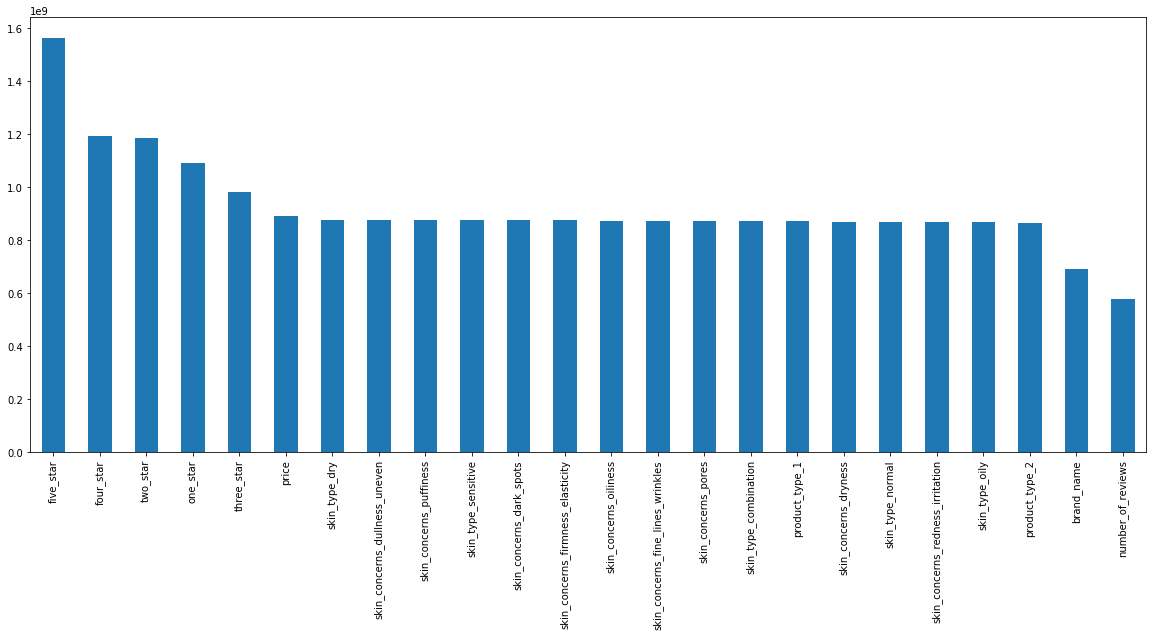

In [13]:
# create empty array to store the mean square error of each feature
mse_values = []
for feature in X_train.columns:
    clf = DecisionTreeRegressor()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict(X_test[feature].fillna(0).to_frame())
    mse_values.append(mean_squared_error(y_test, y_scored))
    
mse_values = pd.Series(mse_values)
mse_values.index = X_train.columns
mse_values.sort_values(ascending=False)
mse_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [14]:
# choosing the top 18 columns
mse_columns=list(mse_values.nsmallest(18).to_dict().keys())


In [15]:
X_train_mse = X_train[mse_columns]
X_test_mse = X_test[mse_columns]


In [16]:
X_train_mse.head()

,number_of_reviews,brand_name,product_type_2,skin_type_oily,skin_type_normal,skin_concerns_redness_irritation,skin_concerns_dryness,product_type_1,skin_type_combination,skin_concerns_pores,skin_concerns_fine_lines_wrinkles,skin_concerns_oiliness,skin_concerns_firmness_elasticity,skin_concerns_dark_spots,skin_type_sensitive,skin_concerns_puffiness,skin_concerns_dullness_uneven,skin_type_dry
0,-0.410213,-0.012188,-0.684261,False,True,True,False,-0.552032,True,True,True,False,False,False,False,False,True,True
1,-0.423237,-0.927838,-0.832955,True,True,True,False,-0.897499,True,False,True,False,True,False,True,True,False,True
2,-0.337278,-0.578227,-0.986354,True,True,True,False,-1.262924,True,False,True,False,False,True,False,False,True,True
3,-0.373745,0.018981,-0.684261,True,False,False,False,-0.552032,True,False,False,False,False,False,False,False,False,True
4,-0.100241,2.509945,1.027722,True,False,False,False,0.668561,True,True,False,False,False,False,False,False,True,False


### 3. Remove features using Lasso

In [17]:
X_test.isnull().mean().sort_values(ascending=True)

brand_name                           0.0
three_star                           0.0
four_star                            0.0
five_star                            0.0
skin_concerns_redness_irritation     0.0
skin_concerns_puffiness              0.0
skin_concerns_oiliness               0.0
skin_concerns_dryness                0.0
skin_concerns_dullness_uneven        0.0
skin_concerns_firmness_elasticity    0.0
skin_concerns_dark_spots             0.0
skin_concerns_pores                  0.0
skin_concerns_fine_lines_wrinkles    0.0
skin_type_sensitive                  0.0
skin_type_oily                       0.0
skin_type_combination                0.0
skin_type_dry                        0.0
skin_type_normal                     0.0
price                                0.0
number_of_reviews                    0.0
product_type_2                       0.0
product_type_1                       0.0
two_star                             0.0
one_star                             0.0
dtype: float64

In [18]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))
# fit a lasso and selet features, make sure to select l1
sel_ = SelectFromModel(Lasso(alpha=100))
sel_.fit(scaler.transform(X_train), y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]


In [19]:
X_train_lasso.shape, X_test_lasso.shape

((1892, 19), (811, 19))

In [20]:
X_train_lasso.columns

Index(['brand_name', 'product_type_1', 'product_type_2', 'number_of_reviews',
       'price', 'skin_type_combination', 'skin_type_oily',
       'skin_type_sensitive', 'skin_concerns_pores',
       'skin_concerns_dark_spots', 'skin_concerns_firmness_elasticity',
       'skin_concerns_dullness_uneven', 'skin_concerns_dryness',
       'skin_concerns_oiliness', 'skin_concerns_puffiness', 'five_star',
       'four_star', 'three_star', 'one_star'],
      dtype='object')

### 4. Select features by random forests derived importance

In [21]:
# select features using the impotance derived from
# random forests

sel_ = SelectFromModel(RandomForestRegressor(n_estimators=400))
sel_.fit(X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_rf = pd.DataFrame(sel_.transform(X_train))
X_test_rf = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_rf.columns = X_train.columns[(sel_.get_support())]
X_test_rf.columns = X_train.columns[(sel_.get_support())]

/Users/audreytang/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [22]:
X_train_rf.shape, X_test_rf.shape

((1892, 4), (811, 4))

In [23]:
X_train.shape, X_test.shape


((1892, 24), (811, 24))

### Fitting in machine learning algorithms

In [24]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict(X_train)
    print('Random Forests R2: {}'.format(r2_score(y_train, pred)))
    print('Test set')
    pred = rf.predict(X_test)
    print('Random Forests R2: {}'.format(r2_score(y_test, pred)))


In [25]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set
Random Forests R2: 0.8123712843455874
Test set
Random Forests R2: 0.7417169755753901


In [26]:
run_randomForests(X_train_basic,
                  X_test_basic,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set
Random Forests R2: 0.8121063316230883
Test set
Random Forests R2: 0.7400092258553744


In [27]:
run_randomForests(X_train_mse,
                  X_test_mse,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set
Random Forests R2: 0.7836045832726842
Test set
Random Forests R2: 0.7328789260086646


In [28]:
run_randomForests(X_train_lasso,
                  X_test_lasso,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set
Random Forests R2: 0.8113561646301417
Test set
Random Forests R2: 0.739686695735633


In [29]:
run_randomForests(X_train_rf,
                  X_test_rf,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set
Random Forests R2: 0.8073779497112532
Test set
Random Forests R2: 0.7389421292617777


In [30]:
# create a function to build linear regression and compare performance in train and test set

def run_linear(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LinearRegression()
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict(X_train)
    print('Linear Regression R2: {}'.format(r2_score(y_train, pred)))
    print('Test set')
    pred = logit.predict(X_test)
    print('Linear Regression R2: {}'.format(r2_score(y_test, pred)))
    

In [31]:

scaler = StandardScaler().fit(X_train)

run_linear(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

Train set
Linear Regression R2: 0.6682823372108286
Test set
Linear Regression R2: 0.6674402655508858


In [36]:
scaler = StandardScaler().fit(X_train_basic)

run_linear(scaler.transform(X_train_basic),
             scaler.transform(X_test_basic),
                  y_train, y_test)

Train set
Linear Regression R2: 0.6682823372108286
Test set
Linear Regression R2: 0.6674402655508859


In [32]:

scaler = StandardScaler().fit(X_train_mse)

run_linear(scaler.transform(X_train_mse),
             scaler.transform(X_test_mse),
                  y_train, y_test)

Train set
Linear Regression R2: 0.666972795086471
Test set
Linear Regression R2: 0.6656849834057565


In [33]:

scaler = StandardScaler().fit(X_train_lasso)

run_linear(scaler.transform(X_train_lasso),
             scaler.transform(X_test_lasso),
                  y_train, y_test)

Train set
Linear Regression R2: 0.668232806499857
Test set
Linear Regression R2: 0.6675969636542143


In [34]:

scaler = StandardScaler().fit(X_train_rf)

run_linear(scaler.transform(X_train_rf),
             scaler.transform(X_test_rf),
                  y_train, y_test)

Train set
Linear Regression R2: 0.6602375459659903
Test set
Linear Regression R2: 0.672282410199771


### Saving data

In [35]:
X_train.to_csv('X_train', index=False)
X_test.to_csv('X_test',index=False)